# Cancer Classification

In this tutorial, we demonstrate how to integrate **patient multiomics data** to enhance **cancer classification**.

This notebook builds on the work of **Huang et al. (Nature Communication, 2021)**, which present a novel multi-omics integrative method named **M**ulti-**O**mics **G**raph c**O**nvolutional **NET**works (MOGONET) and jointly explores omics-specific learning and cross-omics correlation learning for effective multiomics data classification by including mRNA expression data, DNA methylation data, and microRNA expression data.

---

**Objective**

TBC

## Setup

As a starting point, we will install the required packages and load a set of helper functions to assist throughout this tutorial. To keep the output clean and focused on interpretation, we will also suppress warnings.

Moreover, we provide helper functions that can be inspected directly in the `.py` files located in the notebook's current directory. The two additional helper scripts are:
- `config.py`: Defines the base configuration settings, which can be overridden using a custom `.yaml` file.
- `parsing.py`: Contains utilities to compile evaluation results from the training process.

In [1]:
import os
import warnings

warnings.filterwarnings("ignore")
os.environ["PYTHONWARNINGS"] = "ignore"

### Packages

The main packages required for this tutorialare PyKale and PyTorch Geometric.

**PyKale** is an open-source interdisciplinary machine learning library developed at the University of Sheffield, with a focus on applications in biomedical and scientific domains.

**PyG** (PyTorch Geometric) is a library built upon  PyTorch to easily write and train Graph Neural Networks (GNNs) for a wide range of applications related to structured data.

Other required packages can be found in `embc-mmai25/requirements.txt`

#### TIPS
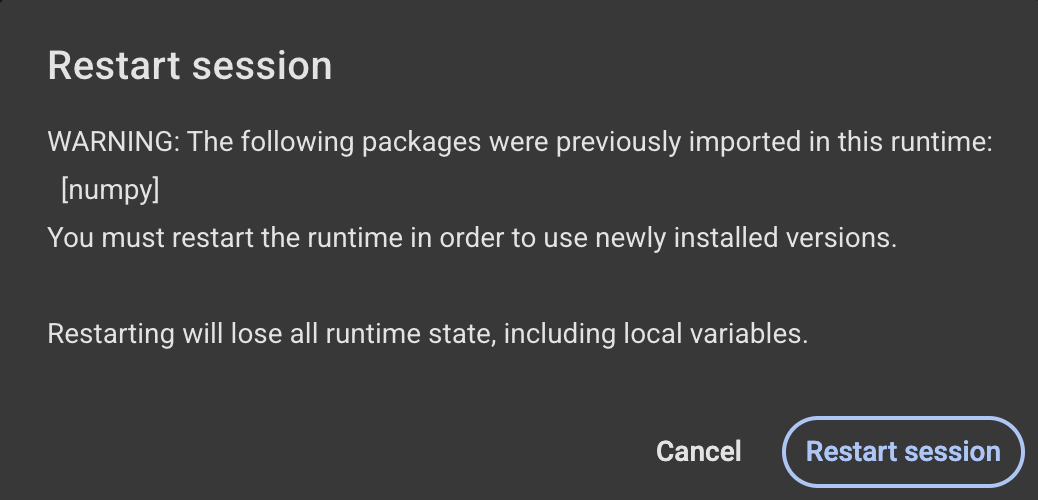
If the notebook shows a pop window like the figure after running the following block, please click `Restart session`. After restarting, **DO NOT** run the following package installation clock again. Just continue running the other blocks from `Configuration` section.

In [2]:
! rm -rf /content/embc-mmai25
!git clone --branch multiomics https://github.com/pykale/embc-mmai25.git

%cd /content/embc-mmai25/tutorials/multiomics-cancer-classification

!pip install --quiet git+https://github.com/pykale/pykale@main\
    && echo "PyKale installed successfully ✅" \
    || echo "Failed to install PyKale ❌"
!pip install --quiet -r /content/embc-mmai25/requirements.txt \
    && echo "Required packages installed successfully ✅" \
    || echo "Failed to install required packages ❌"
import torch
import os
os.environ['TORCH'] = torch.__version__
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git \
    && echo "PyG installed successfully ✅" \
    || echo "Failed to install PyG ❌"
!pip install --upgrade --force-reinstall numpy==2.0.0

Cloning into 'embc-mmai25'...
remote: Enumerating objects: 1115, done.
remote: Counting objects: 100% (136/136), done.
remote: Compressing objects: 100% (94/94), done.
remote: Total 1115 (delta 54), reused 91 (delta 38), pack-reused 979 (from 1)
Receiving objects: 100% (1115/1115), 128.52 MiB | 6.73 MiB/s, done.
Resolving deltas: 100% (510/510), done.
/content/embc-mmai25/tutorials/multiomics-cancer-classification
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.3/812.3 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.2/779.2 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.

## Configuration

To minimize the footprint of the notebook when specifying configurations, we provide a `config.py` file that defines default parameters. These can be customized by supplying a `.yaml` configuration file, such as `experiments/base.yaml` as an example.

In this tutorial, we list the hyperparameters we would like users to play with outside the `.yaml` file:
- `cfg.SOLVER.MAX_EPOCHS_PRETRAIN`: Number of epochs in pre-training stage.
- `cfg.SOLVER.MAX_EPOCHS`: Number of epochs in training stage.
- `cfg.DATASET.NUM_MODALITIES`: Number of modalities in the pipeline.
  - `1`: mRNA expression.
  - `2`: mRNA expression + DNA methylation.
  - `3`: mRNA expression + DNA methylation + miRNA expression.

In [2]:
%cd /content/embc-mmai25/tutorials/multiomics-cancer-classification

from config import get_cfg_defaults

cfg = get_cfg_defaults()
cfg.merge_from_file("experiments/base.yaml")
# ------ Hyperparameters to play with -----
cfg.SOLVER.MAX_EPOCHS_PRETRAIN = 500
cfg.SOLVER.MAX_EPOCHS = 2500
cfg.DATASET.NUM_MODALITIES = 3  # user can change this to try different numbers of modalities.
# -----------------------------------------
cfg.freeze()
print(cfg)


/content/embc-mmai25/tutorials/multiomics-cancer-classification
DATASET:
  NAME: TCGA_BRCA
  NUM_CLASSES: 5
  NUM_MODALITIES: 3
  RANDOM_SPLIT: False
  ROOT: dataset/
  URL: https://github.com/pykale/data/raw/main/multiomics/TCGA_BRCA.zip
MODEL:
  EDGE_PER_NODE: 10
  EQUAL_WEIGHT: False
  GCN_DROPOUT_RATE: 0.5
  GCN_HIDDEN_DIM: [400, 400, 200]
  GCN_LR: 0.0005
  GCN_LR_PRETRAIN: 0.001
  VCDN_LR: 0.001
OUTPUT:
  OUT_DIR: ./outputs
SOLVER:
  MAX_EPOCHS: 2500
  MAX_EPOCHS_PRETRAIN: 500
  SEED: 2023


## Data Loading

We use the preprocessed multiomics benchmark, BRCA, which have been provided by the authors of MOGONET paper in [their repository](https://github.com/txWang/MOGONET).
A brief description of BRCA dataset is shown in the following
table.

**Table 1**: Characteristics of the preprocessed BRCA multiomics dataset.

|      Omics       | #Training samples | #Test samples | #Features |
|:----------------:|:-----------------:|:-------------:|:---------:|
| mRNA expression  |        612        |      263      |   1000    |
| DNA methylation  |        612        |      263      |   1000    |
| miRNA expression |        612        |      263      |    503    |

Note: These datasets have been processed following the **Preprocessing** section of the original paper.

In [3]:
import torch
from kale.loaddata.multiomics_datasets import SparseMultiomicsDataset
from kale.prepdata.tabular_transform import ToOneHotEncoding, ToTensor

print("\n==> Preparing dataset...")
file_names = []
for modality in range(1, cfg.DATASET.NUM_MODALITIES + 1):
    file_names.append(f"{modality}_tr.csv")
    file_names.append(f"{modality}_lbl_tr.csv")
    file_names.append(f"{modality}_te.csv")
    file_names.append(f"{modality}_lbl_te.csv")
    file_names.append(f"{modality}_feat_name.csv")

multiomics_data = SparseMultiomicsDataset(
    root=cfg.DATASET.ROOT,
    raw_file_names=file_names,
    num_modalities=cfg.DATASET.NUM_MODALITIES,
    num_classes=cfg.DATASET.NUM_CLASSES,
    edge_per_node=cfg.MODEL.EDGE_PER_NODE,
    url=cfg.DATASET.URL,
    random_split=cfg.DATASET.RANDOM_SPLIT,
    equal_weight=cfg.MODEL.EQUAL_WEIGHT,
    pre_transform=ToTensor(dtype=torch.float),
    target_pre_transform=ToOneHotEncoding(dtype=torch.float),
)

print(multiomics_data)


==> Preparing dataset...


Extracting dataset/raw/TCGA_BRCA.zip
Processing...
/usr/local/lib/python3.11/dist-packages/kale/prepdata/tabular_transform.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(data_tensor, dtype=self.dtype, device=self.device)
/usr/local/lib/python3.11/dist-packages/kale/prepdata/tabular_transform.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(data_tensor, dtype=self.dtype, device=self.device)



Dataset info:
   number of modalities: 3
   number of classes: 5

   modality | total samples | num train | num test  | num features
   -----------------------------------------------------------------
   1        | 875           | 612       | 263       | 1000        
   2        | 875           | 612       | 263       | 1000        
   3        | 875           | 612       | 263       | 503         
   -----------------------------------------------------------------




/usr/local/lib/python3.11/dist-packages/kale/prepdata/tabular_transform.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(data_tensor, dtype=self.dtype, device=self.device)
Done!


## Initialize the Model Wrapper
We start by importing and initializing the `MogonetModel` class from `model.py`, which wraps all the necessary components of the MOGONET pipeline based on the configuration.

This wrapper takes care of:
- Building GCN encoders for each omics modality.
- Creating linear classifiers for modality-specific outputs.
- Optionally initializing a VCDN decoder for multimodal fusion.

### API Descriptions

`model.py` includes the following `PyKale` APIs:
- `kale.embed.mogonet` provides `MogonetGCN`, which is the basic layer of the unimodal encoder. It applies a graph convolutional network (GCN) to each omics modality individually, allowing for local feature learning based on sample-sample similarity graphs.

- `kale.loaddata.multiomics_datasets` provides `SparseMultiomicsDataset`, a dataset class tailored for handling multiple omics modalities with sparse graph structures. It allows retrieving modality-specific data and supports graph-based learning frameworks like PyTorch Geometric.

- `kale.pipeline.multiomics_trainer` provides `MultiomicsTrainer`, the training and evaluation engine that orchestrates how unimodal encoders, decoders, and the multimodal VCDN fusion layer work together. It supports pretraining and full training regimes.

- `kale.predict.decode.LinearClassifier` provides a lightweight feedforward decoder for classifying features extracted from each modality. It is used after each unimodal encoder to make modality-specific predictions.

- `kale.predict.decode.VCDN` implements the View Correlation Discovery Network (VCDN), which fuses modality-specific predictions into a joint representation for final classification. It captures correlations between different modalities at the decision level.


In [4]:
from model import MogonetModel
mogonet_model = MogonetModel(cfg, dataset=multiomics_data)

## Pretrain Unimodal GCNs
Before training the full multi-omics fusion model, we first pretrain each omics modality independently. This step helps each GCN encoder learn a good representation of its respective omics data before integration.

### What Happens in Pretraining?
During this phase:

- Each modality is trained separately using its own GCN and classifier.

- No information is shared across modalities yet.

- This step ensures modality-specific features are well-learned before fusion.

Once pretrained, the model is ready for multimodal fusion training using the VCDN decoder.

In [5]:
import pytorch_lightning as pl
network = mogonet_model.get_model(pretrain=True)
trainer_pretrain = pl.Trainer(
    max_epochs=cfg.SOLVER.MAX_EPOCHS_PRETRAIN,
    default_root_dir=cfg.OUTPUT.OUT_DIR,
    accelerator="auto",
    devices="auto",
    enable_model_summary=False,
)
trainer_pretrain.fit(network)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=500` reached.


## Train the Full Multimodal Model
After pretraining the unimodal pathways, we now train the full MOGONET model by enabling the **VCDN-based multimodal fusion**.

### What Happens Here?
- The pretrained unimodal encoders are reused as feature extractors.

- The VCDN decoder is trained to integrate outputs across all modalities.

- This setup allows joint learning from all omics data types for improved cancer classification performance.

In [7]:
network = mogonet_model.get_model(pretrain=False)
trainer = pl.Trainer(
    max_epochs=cfg.SOLVER.MAX_EPOCHS,
    default_root_dir=cfg.OUTPUT.OUT_DIR,
    accelerator="auto",
    devices="auto",
    enable_model_summary=False,
    log_every_n_steps=1,
)
trainer.fit(network)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Model info:
   Unimodal encoder:
    (1) MogonetGCN(
  (conv1): MogonetGCNConv(1000, 400)
  (conv2): MogonetGCNConv(400, 400)
  (conv3): MogonetGCNConv(400, 200)
)    (2) MogonetGCN(
  (conv1): MogonetGCNConv(1000, 400)
  (conv2): MogonetGCNConv(400, 400)
  (conv3): MogonetGCNConv(400, 200)
)    (3) MogonetGCN(
  (conv1): MogonetGCNConv(503, 400)
  (conv2): MogonetGCNConv(400, 400)
  (conv3): MogonetGCNConv(400, 200)
)

  Unimodal decoder:
    (1) LinearClassifier(
  (fc): Linear(in_features=200, out_features=5, bias=True)
)    (2) LinearClassifier(
  (fc): Linear(in_features=200, out_features=5, bias=True)
)    (3) LinearClassifier(
  (fc): Linear(in_features=200, out_features=5, bias=True)
)

  Multimodal decoder:
    VCDN(
  (model): Sequential(
    (0): Linear(in_features=125, out_features=125, bias=True)
    (1): LeakyReLU(negative_slope=0.25)
    (2): Linear(in_features=125, out_features=5, bias=True)
  )
)


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2500` reached.


## Evaluate the Trained MOGONET Model
Once training is complete, we evaluate the model on the test set using `trainer.test()`.

### What is included in this step?
- Load the best model checkpoint.
- Run the model on the test split from the dataset.
- Return classification metrics such as accuracy, F1 score, etc.

In [8]:
_ = trainer.test(network)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 875. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Accuracy          │    0.7720000147819519     │
│         F1 macro          │    0.6600000262260437     │
│        F1 weighted        │    0.7400000095367432     │
└───────────────────────────┴───────────────────────────┘

## Interpretation Study - Identify Important Biomarkers
After training and evaluating the model, we can interpret its decisions by identifying the most influential features (biomarkers) using **feature-masking-based importance analysis**.

PyKale provides a utility function, `kale.interpret.model_weights.select_top_features_by_masking`, that systematically masks input features and observes the effect on performance—highlighting which features are most important for classification.

### How Feature Importance Is Computed?
The `select_top_features_by_masking` function in `PyKale` implements a feature ablation approach to estimate feature importance for multi-omics data.


For each feature in each modality:

- Temporarily mask (zero out) the feature.

- Evaluate the model on the test set.

- Measure the performance drop (e.g., in F1 score). The larger the drop, the more important the feature is.

- Importance is calculated as $Importance_j=(FullMetric-MaskedMetric_j)\times d$,
where $j$ is the feature index and $d$ is the number of features in the modality (to scale the effect)

For demonstration, we use **F1 score** as the metric to calculate feature importance.

In [17]:
from kale.interpret.model_weights import select_top_features_by_masking

trainer_biomarker = pl.Trainer(
    max_epochs=cfg.SOLVER.MAX_EPOCHS,
    accelerator="auto",
    devices="auto",
    enable_progress_bar=False,
)

f1_key = "F1" if multiomics_data.num_classes == 2 else "F1 macro"
df_featimp_top = select_top_features_by_masking(
    trainer=trainer_biomarker,
    model=network,
    dataset=multiomics_data,
    metric=f1_key,
    num_top_feats=30,
    verbose=False,
)

print("{:>4}\t{:<20}\t{:>5}\t{}".format("Rank", "Feature name", "Omics", "Importance"))
for rank, row in enumerate(df_featimp_top.itertuples(index=False), 1):
    print(f"{rank:>4}\t{row.feat_name:<20}\t{row.omics:>5}\t{row.imp:.4f}")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Features (Modality 0):   9%|▉         | 91/1000 [00:12<02:07,  7.13it/s]INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


KeyboardInterrupt: 